In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


In [14]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'../../dgym-data/Mpro_prepped.pdbqt',
    config=config
)

CPU times: user 2 s, sys: 41.6 ms, total: 2.04 s
Wall time: 318 ms


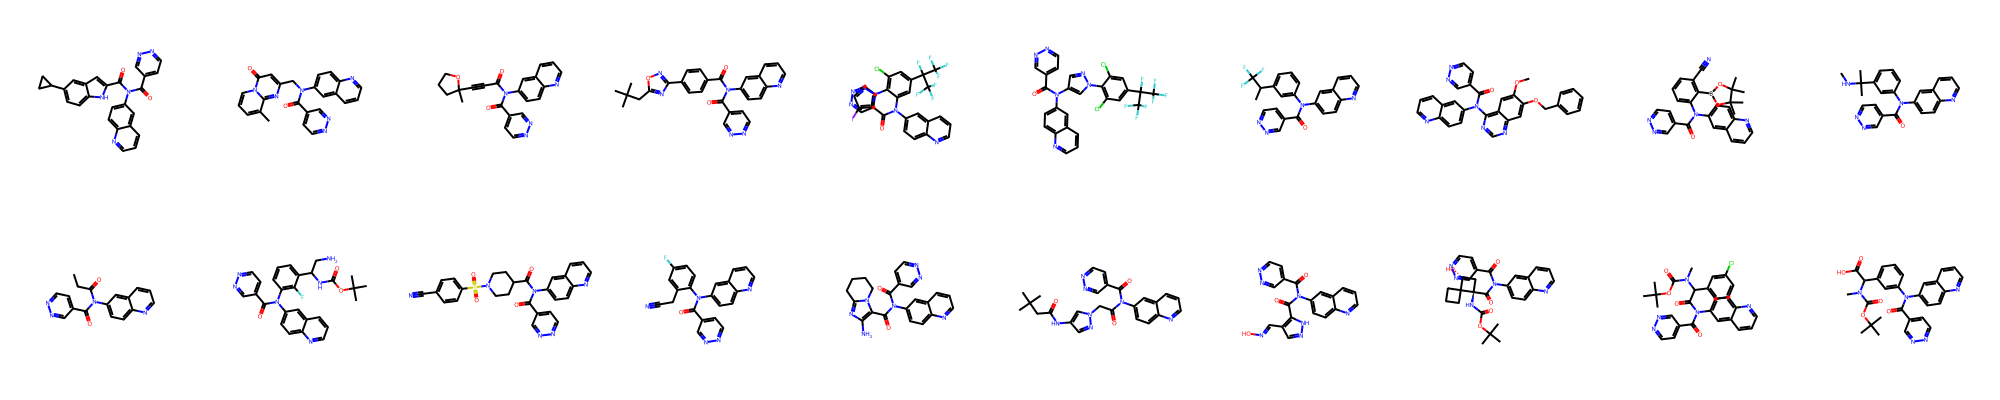

In [457]:
%%time
# molecule = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1nnc2ccccc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]nnc2ccccc12']
# )

from rdkit.Chem.Draw import MolsToGridImage

library_designer.reset_cache()
molecules = library_designer.design(
    molecules[5],
    size=20,
    mode='expand',
    temperature=0.0
)
MolsToGridImage([m.mol for m in molecules], molsPerRow=10)

In [532]:
molecules[7].reactants[1].reactants[1].smiles

'Nc1ccc2ncccc2c1'

In [165]:
expanded_molecule = molecules[4]

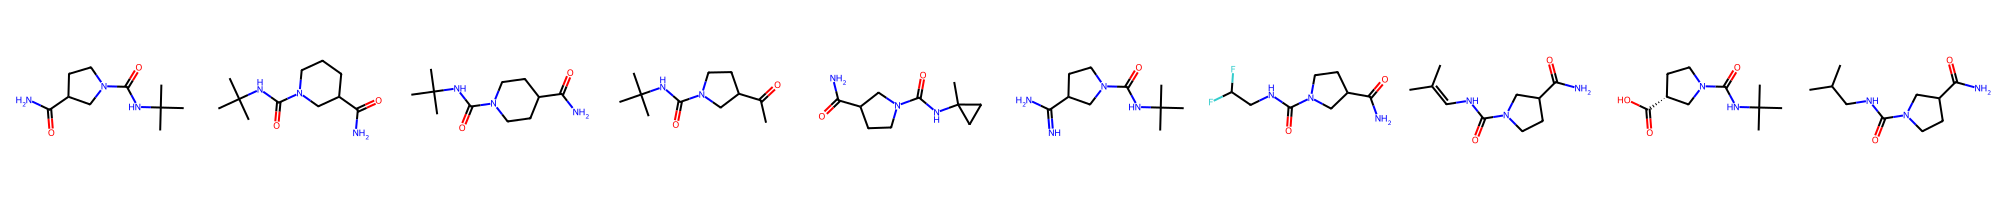

In [229]:
library_designer.reset_cache()
prods = library_designer.design(
    expanded_molecule.reactants[1],
    size = 10,
    mode = 'analog',
)

MolsToGridImage([p.mol for p in prods], molsPerRow=10)

In [419]:
from rdkit import Chem

def reconstruct_molecule(molecule):
    """
    Recursively reconstructs the original molecule from its reactants and reactions.

    Parameters
    ----------
    molecule : Molecule
        The molecule to be reconstructed.

    Returns
    -------
    Molecule
        The reconstructed original molecule.

    Notes
    -----
    - The function assumes that the `Molecule` data structure has attributes `reactants` and `reaction`.
    - The `reactants` attribute is expected to be a list of `Molecule` instances.
    - The `reaction` attribute is assumed to be a wrapper around RDKit that can run reactions.
    - The function recurses down the reactant/reaction tree until base molecules are reached.
    """
    # Base case: If molecule has no reactants, return molecule itself
    if not molecule.reactants:
        return molecule

    # Recursive case: Reconstruct each reactant
    reconstructed_reactants = [reconstruct_molecule(reactant) for reactant in molecule.reactants]

    # Use the reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(reconstructed_reactants)[0][0]
    
    # products = []
    # for product in output[0]:
    if original_molecule := sanitize(output):
        return original_molecule
        # products.append(original_molecule)

    return products

def sanitize(mol):

    # Sanitize
    smiles = Chem.MolToSmiles(mol)
    product = Chem.MolFromSmiles(smiles)
    return product

  0%|          | 0/5 [00:00<?, ?it/s]

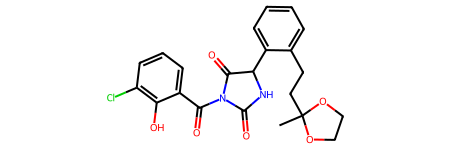

4.187648811909822


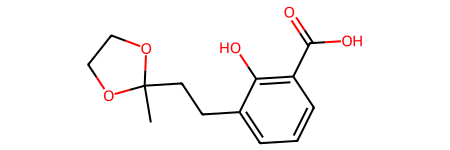

4.47425223998464


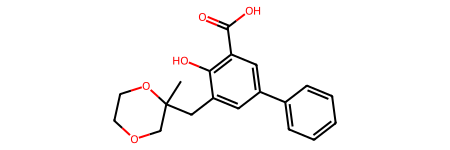

4.603938777273891


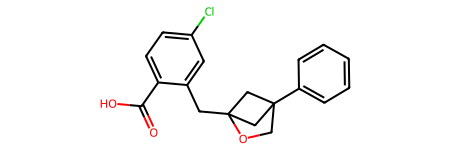

5.036640125791382


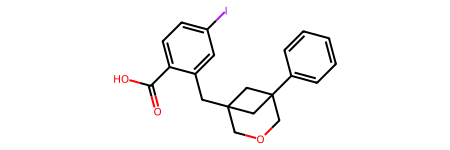

4.9253029732232605


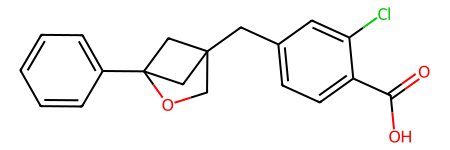

5.2659620819030675


In [546]:
import numpy as np
from tqdm.notebook import tqdm

# best_mol = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1cnc2ccc(F)cc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]cnc2ccc(F)cc12']
# )
# best_mol = deck[414]
# best_score = docking_oracle([best_mol])

# mols = dg.collection.MoleculeCollection([best_mol])
# all_scores = [best_score]

for _ in tqdm(range(5)):
    
    display(best_mol)
    print(best_score)
    
    analogs = library_designer.design(
        best_mol,
        mode='retrosynthesize',
        temperature=0.3,
        size=10
    )
    mols += analogs

    scores = docking_oracle(analogs)
    all_scores.extend(scores)
    
    best = np.nanargmax(scores).item()
    best_score = scores[best]
    best_mol = analogs[best]
    
display(best_mol)
print(best_score)

In [544]:
analogs

MoleculeCollection with 51 Molecules

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


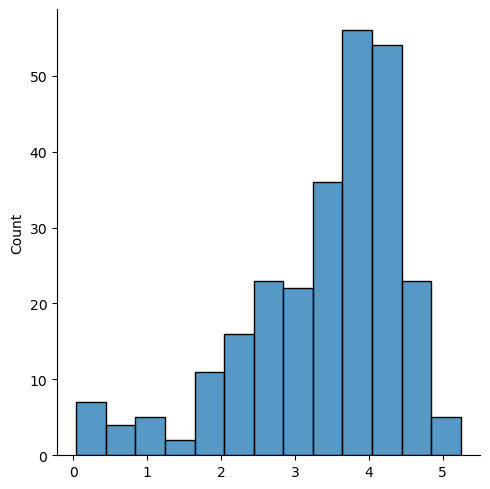

In [545]:
import seaborn as sns
pIC50s = np.array(docking_oracle(mols))
sns.displot(pIC50s[pIC50s > 0.0])